In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/FedShare-main')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install torch torchvision tensorboard
!pip install tqdm numpy matplotlib

Files already downloaded and verified
Files already downloaded and verified


Aggregation over all clients: 100%|██████████| 100/100 [33:13<00:00, 19.94s/round]


Files already downloaded and verified
Files already downloaded and verified


Aggregation over all clients: 100%|██████████| 100/100 [44:41<00:00, 26.82s/round]


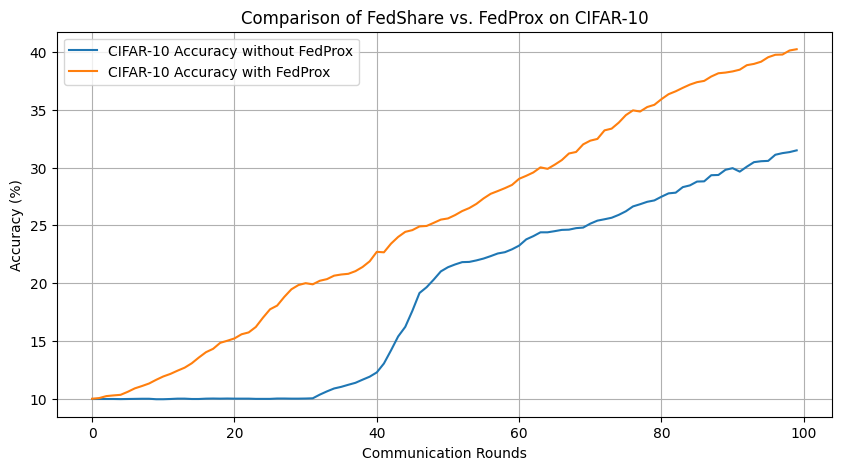

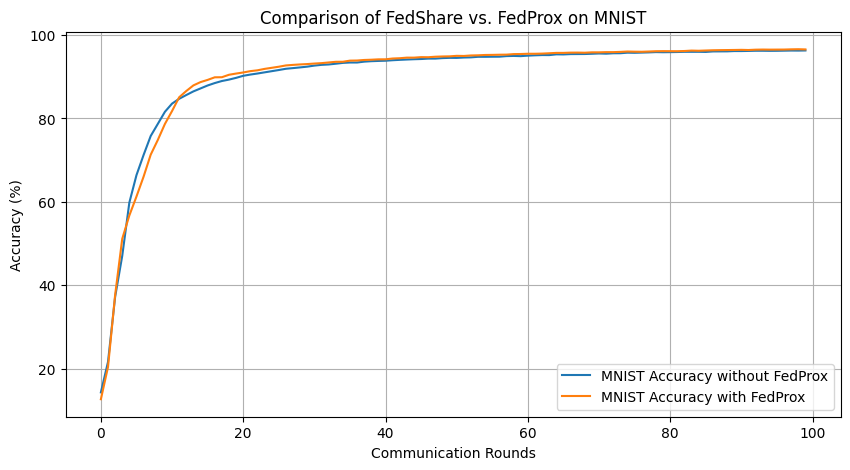

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the CNN model for CIFAR
class CNN_v2(nn.Module):
    def __init__(self, num_channels):
        super(CNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the CNN model for MNIST
class CNN_v1(nn.Module):
    def __init__(self):
        super(CNN_v1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# Define the federated averaging function
def FedAvg(w_locals):
    w_avg = copy.deepcopy(w_locals[0])
    for key in w_avg.keys():
        for i in range(1, len(w_locals)):
            w_avg[key] += w_locals[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w_locals))
    return w_avg

# Testing function to evaluate the model
def test_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, test_loss

# Args class definition for experiment parameters
class Args:
    def __init__(self, dataset):
        self.dataset = dataset
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.num_channels = 3 if dataset == 'cifar' else 1
        self.num_users = 10
        self.frac = 0.3
        self.local_ep = 10
        self.local_bs = 20
        self.lr = 0.001
        self.rounds = 100

# Main experiment function
def main(args, fedprox=False, mu=0.1):
    device = args.device
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) if args.dataset == 'cifar' else transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) if args.dataset == 'cifar' else datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) if args.dataset == 'cifar' else datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    global_model = (CNN_v2(args.num_channels) if args.dataset == 'cifar' else CNN_v1()).to(device)
    accuracies = []

    for round in tqdm(range(args.rounds), desc="Aggregation over all clients", unit="round"):
        local_weights = []
        for i in range(args.num_users):
            local_model = (CNN_v2(args.num_channels) if args.dataset == 'cifar' else CNN_v1()).to(device)
            local_model.load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(local_model.parameters(), lr=args.lr)
            subset_indices = np.random.choice(len(train_set), int(len(train_set) / args.num_users), replace=False)
            train_loader = DataLoader(Subset(train_set, subset_indices), batch_size=args.local_bs, shuffle=True)
            local_model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = local_model(data)
                loss = F.cross_entropy(output, target)
                if fedprox:
                    for param, global_param in zip(local_model.parameters(), global_model.parameters()):
                        loss += (mu / 2) * torch.norm(param - global_param) ** 2
                loss.backward()
                optimizer.step()
            local_weights.append(local_model.state_dict())

        # Update global weights
        global_model.load_state_dict(FedAvg(local_weights))

        # Test the model
        accuracy, _ = test_model(global_model, device, test_loader)
        accuracies.append(accuracy)

    return accuracies
# Initialize Args for CIFAR-10 and MNIST
cifar_args = Args('cifar')
mnist_args = Args('mnist')

# Run experiments with and without FedProx
cifar_accuracies_fedshare = main(cifar_args, fedprox=False)
cifar_accuracies_fedprox = main(cifar_args, fedprox=True, mu=0.01)

mnist_accuracies_fedshare = main(mnist_args, fedprox=False)
mnist_accuracies_fedprox = main(mnist_args, fedprox=True, mu=0.01)

# Plotting the results for CIFAR-10
plt.figure(figsize=(10, 5))
plt.plot(cifar_accuracies_fedshare, label='CIFAR-10 Accuracy without FedProx')
plt.plot(cifar_accuracies_fedprox, label='CIFAR-10 Accuracy with FedProx')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of FedShare vs. FedProx on CIFAR-10')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the results for MNIST
plt.figure(figsize=(10, 5))
plt.plot(mnist_accuracies_fedshare, label='MNIST Accuracy without FedProx')
plt.plot(mnist_accuracies_fedprox, label='MNIST Accuracy with FedProx')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of FedShare vs. FedProx on MNIST')
plt.legend()
plt.grid(True)
plt.show()

